In [1]:
# Authors: Samantha Tetef and Vikram Kashyap
# Date: Winter 2020-2021 to Summer 2021

In [2]:
import warnings
warnings.filterwarnings("ignore")

import utils as u
from importlib import reload
# to reload utils, run:
# u = reload(u)

import os
import copy
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import mplcursors

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pathlib import Path

import webbrowser

warnings.filterwarnings("ignore")

In [3]:
%matplotlib notebook

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

In [5]:
ROOTDIR = Path()

CIDdir = ROOTDIR/"ProcessedData"
Listdir = ROOTDIR/"Categories"

XES_DATA = u.get_Data(Listdir, mode='xes')
XANES_DATA = u.get_Data(Listdir, mode='xanes')

CIDS = u.get_Property(XES_DATA, 'CID')
compoundtypes = u.get_Property(XES_DATA, 'Type')

list of CIDS that have heavy atoms
- 100427
- 101349
- 107980
- 1137
- 114861
- 119105
- 11949961
- 11987823
- 11988266

In [6]:
xes = np.array(u.get_Property(XES_DATA, 'Spectra'))
XESenergy = xes[0,0,:]
XES = xes[:,1,:]

XES_SCALING = np.max(XES)
XES = XES / XES_SCALING

In [7]:
xanes = np.array(u.get_Property(XANES_DATA, 'Spectra'))
XANESenergy = xanes[0,0,:]
XANES = xanes[:,1,:]

XANES_SCALING = np.max(XANES)
XANES = XANES / XANES_SCALING

# ML and Data Science section

## All Spectra Together

<IPython.core.display.Javascript object>


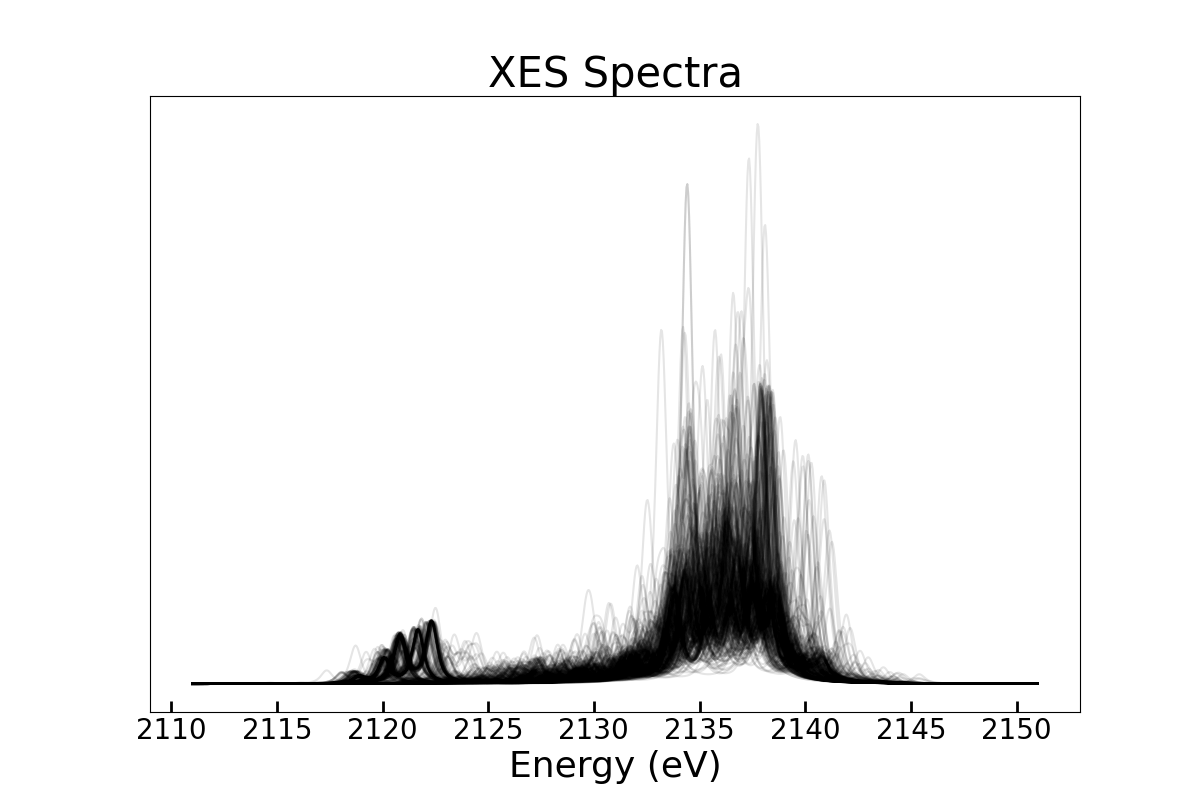

<IPython.core.display.Javascript object>


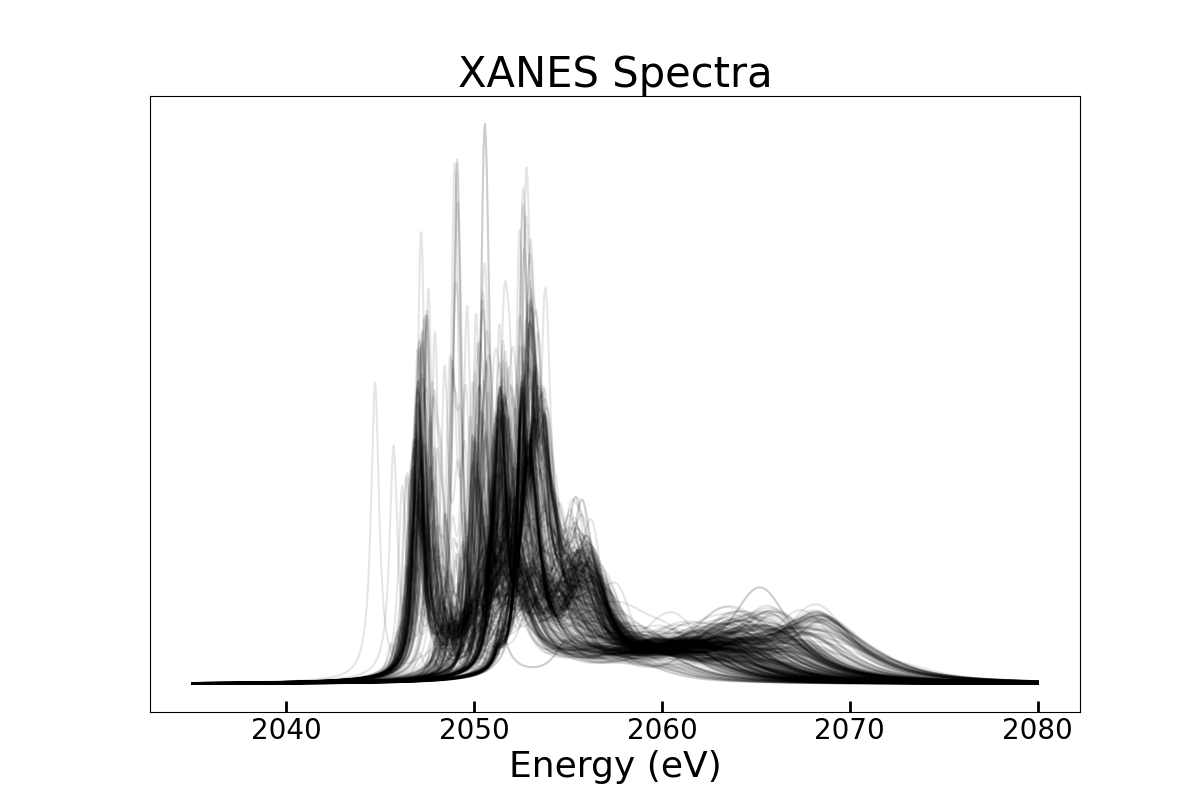

In [8]:
def Spagetti_plot(energy, X, mode='XES', MINIMAX=[0,-1]):
    
    MIN, MAX = MINIMAX
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    for x in X:
        plt.plot(energy, x, '-', c='k', alpha=0.1)
                
    plt.title(f"{mode} Spectra", fontsize=30)
    
    plt.xlabel('Energy (eV)', fontsize=26)
    plt.xticks(fontsize=20)
    ax.tick_params(direction='in', width=2, length=8)
    plt.yticks([])

    plt.show()
    
Spagetti_plot(XESenergy, XES, mode='XES')
Spagetti_plot(XANESenergy, XANES, mode='XANES')

## Rainbow Spaghetti Plot: Color by Whiteline

<IPython.core.display.Javascript object>


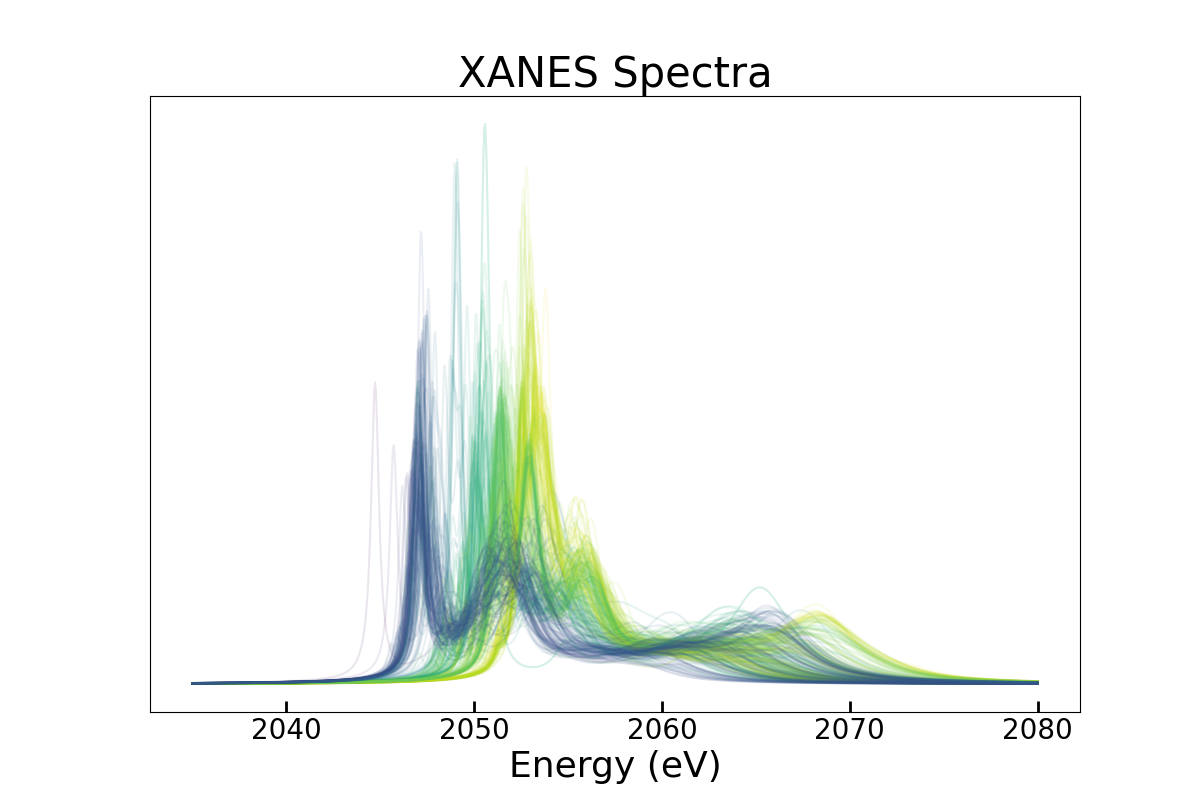

In [9]:
def Rainbow_spaghetti_plot(energy, X, mode='XES', MINIMAX=[0,-1]):
    
    MIN, MAX = MINIMAX
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    min_whiteline, max_whiteline = 500, 0
    for x in X:
        whiteline_idx = np.argmax(x)
        if whiteline_idx < min_whiteline:
            min_whiteline = whiteline_idx
        if whiteline_idx > max_whiteline:
            max_whiteline = whiteline_idx
    total_idx_range = max_whiteline - min_whiteline
    
    for x in X:
        whiteline_idx = np.argmax(x)
        scale = (whiteline_idx - min_whiteline)/total_idx_range
        plt.plot(energy, x, '-', color=plt.cm.viridis(scale), alpha=0.1)
                
    plt.title(f"{mode} Spectra", fontsize=30)
    
    plt.xlabel('Energy (eV)', fontsize=26)
    plt.xticks(fontsize=20)
    ax.tick_params(direction='in', width=2, length=8)
    plt.yticks([])

    plt.show()
    
Rainbow_spaghetti_plot(XANESenergy, XANES, mode='XANES')

## Rainbow Spaghetti Plot: Color and Stack by Whiteline

<IPython.core.display.Javascript object>


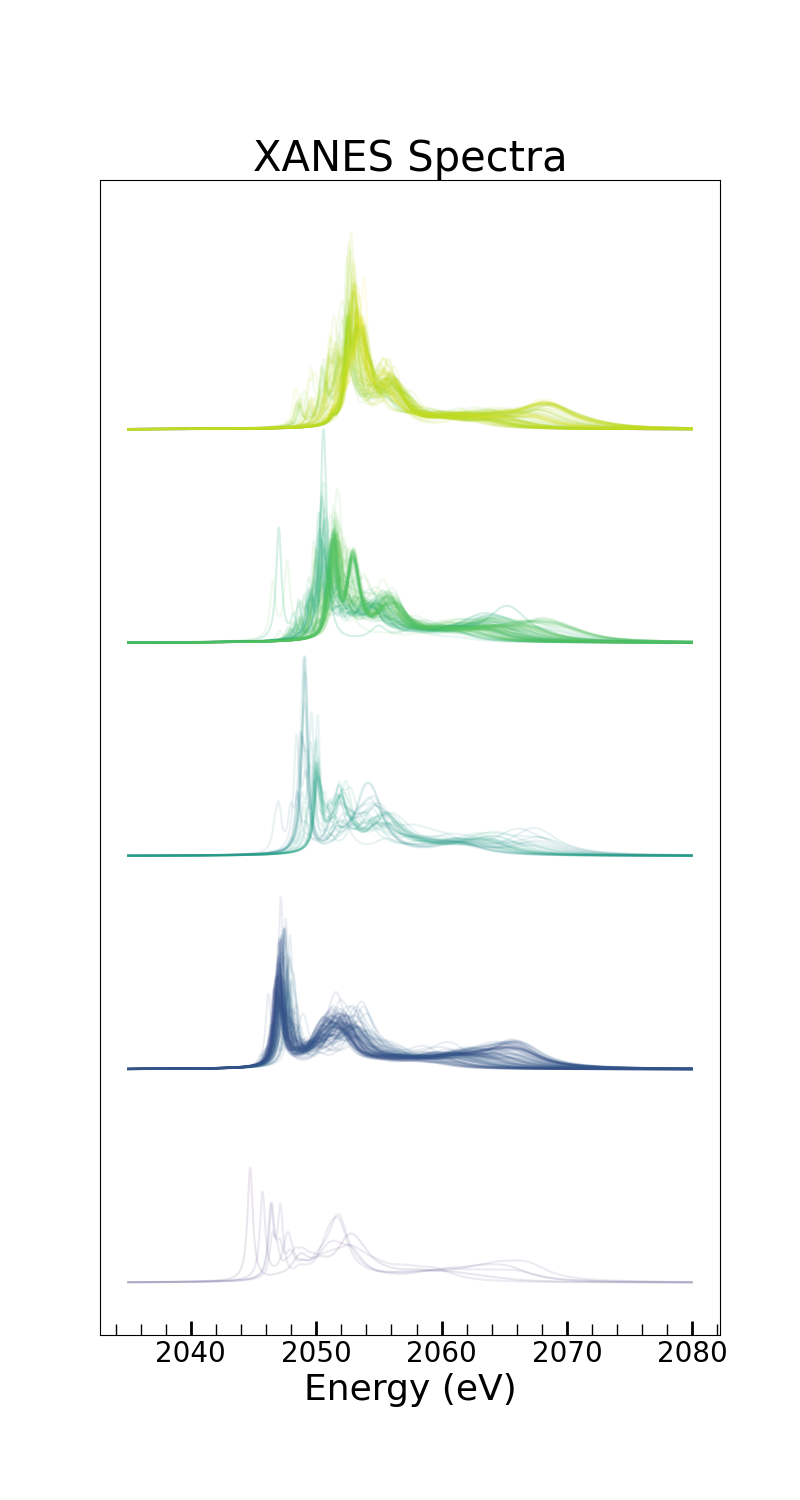

<IPython.core.display.Javascript object>


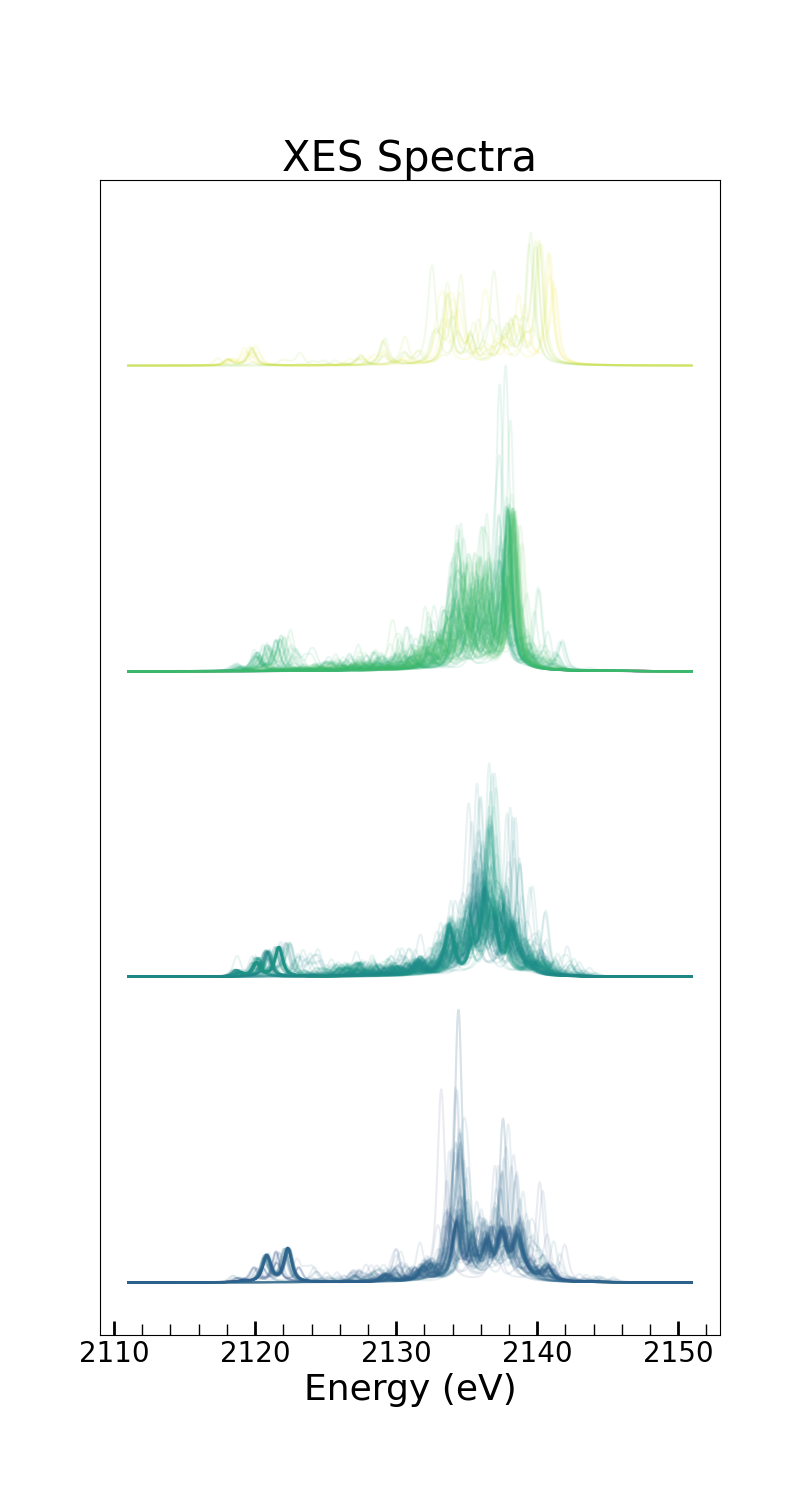

In [10]:
def Rainbow_spaghetti_plot_stack(energy, X, mode='XES', MINIMAX=[0,-1]):
    
    mn, mx = MINIMAX
    
    fig, ax = plt.subplots(figsize=(8,15))
    
    min_whiteline, max_whiteline = 500, 0
    for x in X:
        whiteline_idx = np.argmax(x)
        if whiteline_idx < min_whiteline:
            min_whiteline = whiteline_idx
        if whiteline_idx > max_whiteline:
            max_whiteline = whiteline_idx
    total_idx_range = max_whiteline - min_whiteline
    
    for x in X:
        whiteline_idx = np.argmax(x)
        scale = (whiteline_idx - min_whiteline)/total_idx_range
        bin_num = int(scale*10)//2
        if bin_num == 5:
            bin_num = 4
        plt.plot(energy[mn:mx], x[mn:mx] + bin_num, '-', color=plt.cm.viridis(scale), alpha=0.1)
                
    plt.title(f"{mode} Spectra", fontsize=30)
    
    plt.xlabel('Energy (eV)', fontsize=26)
    ax.tick_params(direction='in', width=2, length=8)
    plt.xticks(fontsize=20)
    
    if mode == 'XANES' or mode == 'XES':
        ax.xaxis.set_minor_locator(MultipleLocator(2))
        ax.xaxis.set_major_locator(MultipleLocator(10))
    
    ax.tick_params(direction='in', width=2, length=10, which='major')
    ax.tick_params(direction='in', width=1, length=8, which='minor')
    plt.yticks([])

    plt.show()
    
Rainbow_spaghetti_plot_stack(XANESenergy, XANES, mode='XANES')
Rainbow_spaghetti_plot_stack(XESenergy, XES, mode='XES')

## Rainbow Spaghetti Plot: Color and Stack by Compound Type

In [11]:
#allCIDS = set(int(f.replace('_xes.dat', '')) for f in os.listdir(CIDdir) if f.endswith('_xes.dat'))

In [12]:
typecodes = {'phosphate_esters':5,
             'phosphite_esters':4,
             'phosphonic_acids':3,
             'phosphenic_acids':2,
             'phosphine_oxides':1,
             'trialkyl_phosphines':0}

In [13]:
def Rainbow_spaghetti_plot_types_stack(subplot, energy, X, types, mode='XES', MINIMAX=[0,-1]):
    mn, mx = MINIMAX
    
    fig, ax = subplot
    
    lines = []
    for x,cid,moltype in zip(X,CIDS,types):
        bin_num = typecodes[moltype]
        lines.append(plt.plot(energy[mn:mx], x[mn:mx] + bin_num, '-', color=plt.cm.viridis(bin_num*50), alpha=0.1,\
                              label=(str(cid)+','+str(moltype)))[0])
        
    plt.title(f"{mode} Spectra", fontsize=30)
    
    plt.xlabel('Energy (eV)', fontsize=26)
    ax.tick_params(direction='in', width=2, length=8)
    plt.xticks(fontsize=20)
    
    if mode == 'XANES' or mode == 'XES':
        ax.xaxis.set_minor_locator(MultipleLocator(2))
        ax.xaxis.set_major_locator(MultipleLocator(10))
    
    ax.tick_params(direction='in', width=2, length=10, which='major')
    ax.tick_params(direction='in', width=1, length=8, which='minor')
    plt.yticks([])
    
    '''
    mplcursors.cursor(lines, highlight=True, \
                      highlight_kwargs={'color':'pink', 'alpha':1, 'linewidth':3, 'markeredgewidth':0})
                     #.connect("add", lambda sel: webbrowser.open(f"https://pubchem.ncbi.nlm.nih.gov/image/imgsrv.fcgi?cid={CIDS[sel.target.index]}&t=l"))
    '''
    
    plt.show()
    
    return lines

<IPython.core.display.Javascript object>


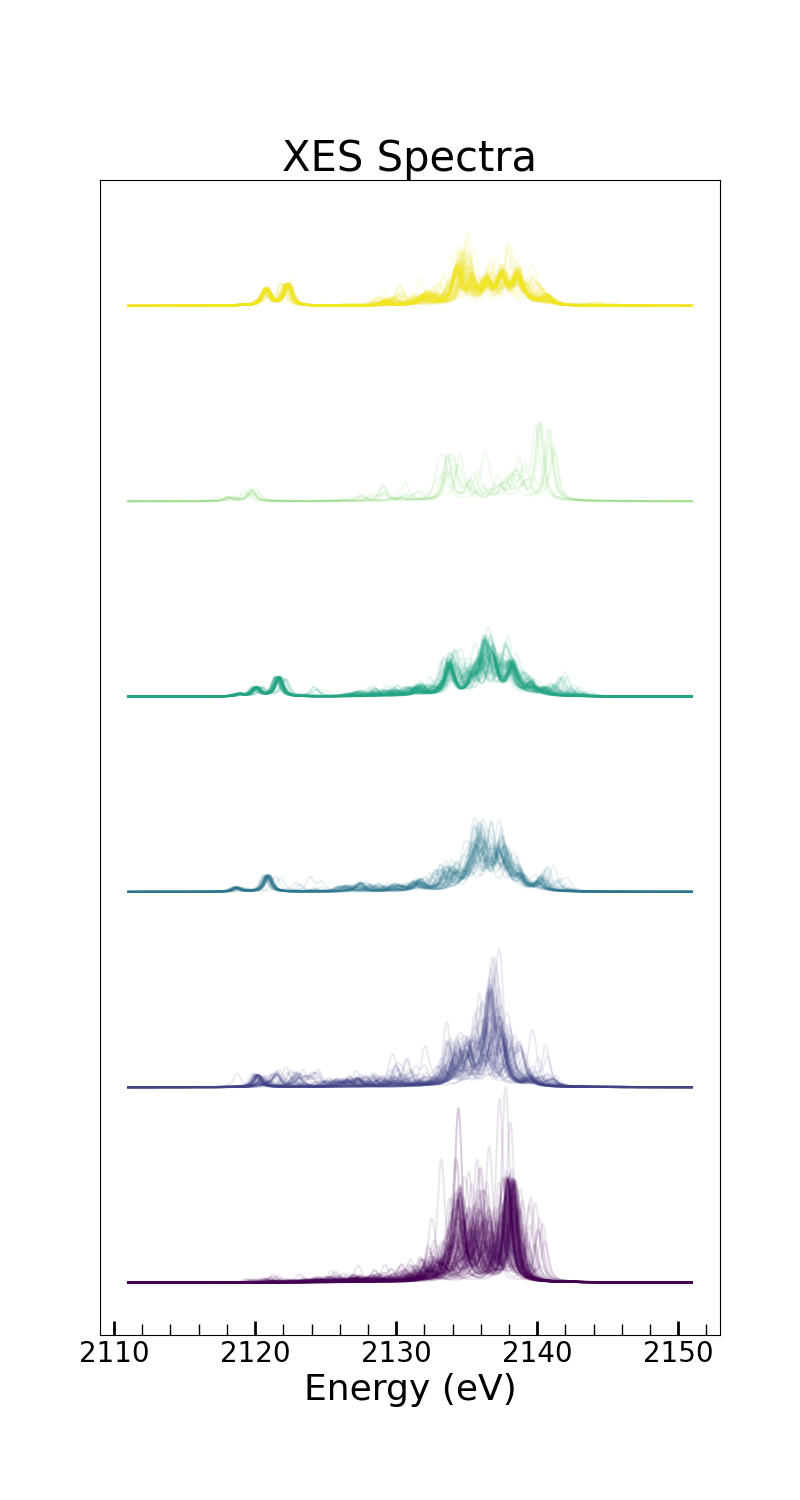

<IPython.core.display.Javascript object>


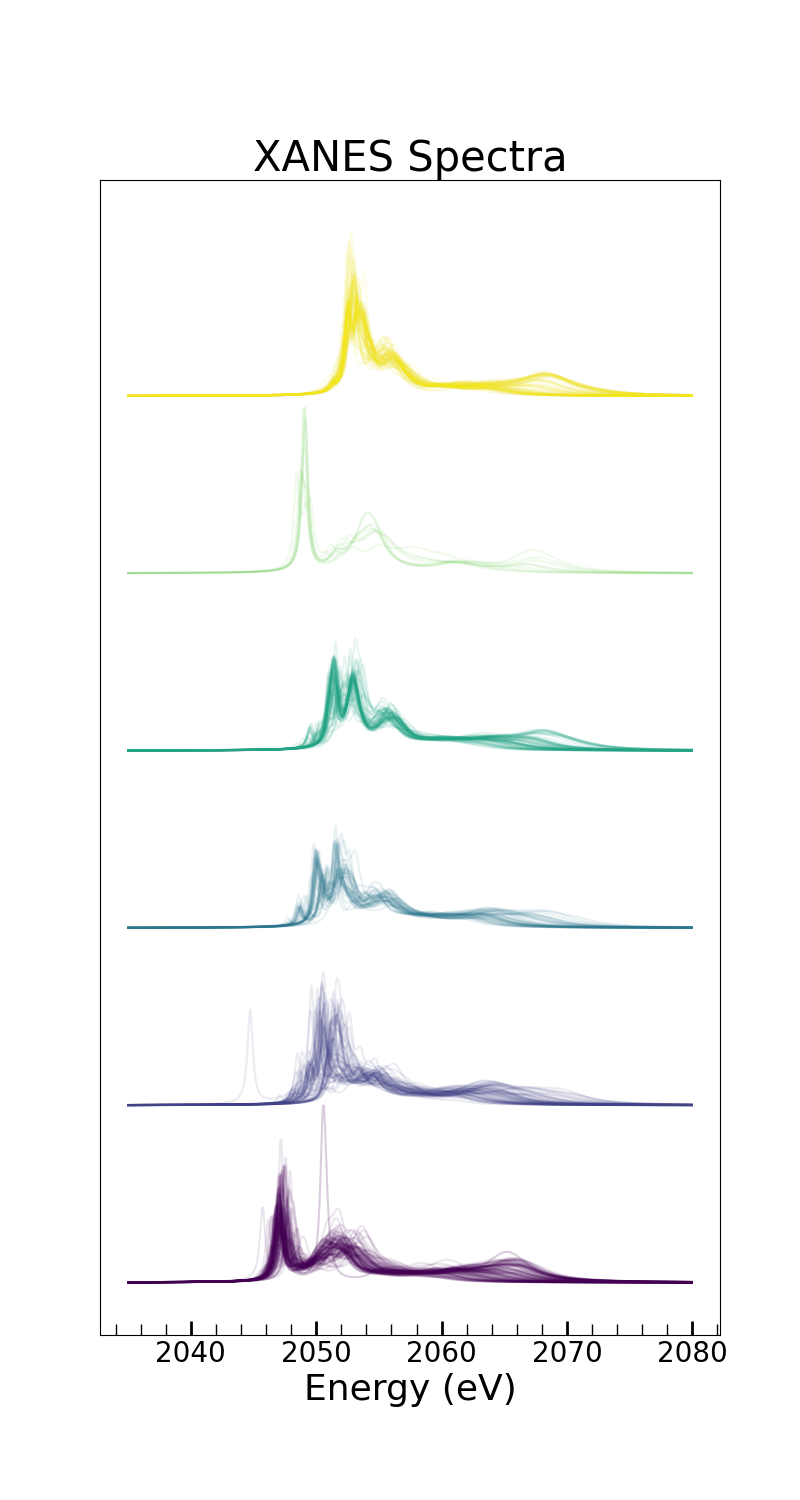

In [14]:
Rainbow_spaghetti_plot_types_stack(plt.subplots(figsize=(8,15)), XESenergy, XES, compoundtypes, mode='XES');
Rainbow_spaghetti_plot_types_stack(plt.subplots(figsize=(8,15)), XANESenergy, XANES, compoundtypes, mode='XANES');

## ML Latent Space: PCA and T-SNE

In [15]:
warnings.filterwarnings("ignore")
# pca
pca1 = PCA(n_components=10)
XES_PCA = pca1.fit_transform(XES)

# pca
pca2 = PCA(n_components=10)
XANES_PCA = pca2.fit_transform(XANES)

# tsne
tsne = TSNE(n_components=2, perplexity=20)
XES_TSNE = tsne.fit_transform(XES)

# tsne
tsne = TSNE(n_components=2, perplexity=20, random_state=30)
XANES_TSNE = tsne.fit_transform(XANES)

In [16]:
def onselect(sel):
        sel.annotation.set_text( \
        str(CIDS[sel.target.index])+','+str(compoundtypes[sel.target.index]))
        webbrowser.open(f"https://pubchem.ncbi.nlm.nih.gov/image/imgsrv.fcgi?cid={CIDS[sel.target.index]}&t=l")
        

def plot_dim_red(plot, X_red, types, method, fontsize=16, mode='VtC-XES'):

    fig, ax = plot
        
    '''
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)
    '''
    
    colors = [typecodes[t]*50 for t in types]
    
    dots = plt.scatter(X_red[:, 0], X_red[:, 1], c=colors)
    
    plt.xticks(fontsize=fontsize+3)
    plt.yticks(fontsize=fontsize+3)
    
    ax.set_xlabel(f"{method} [0]", fontsize=fontsize+6)
    ax.set_ylabel(f"{method} [1]", fontsize=fontsize+6)
    ax.tick_params(direction='in', width=2, length=8)
    
    legend = ax.legend([f'{mode}:\n{method}'], handlelength=0, handletextpad=0,
                           fancybox=True, fontsize=22)
    for item in legend.legendHandles:
        item.set_visible(False)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
        
    plt.show()
    
    return dots

<IPython.core.display.Javascript object>


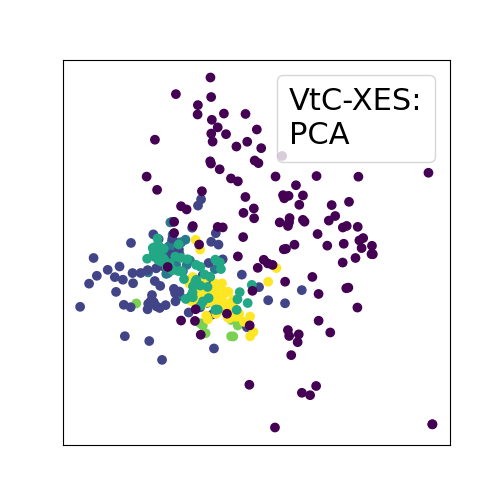

<IPython.core.display.Javascript object>


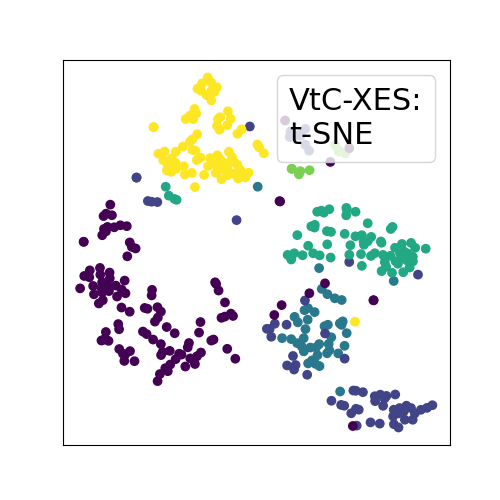

<IPython.core.display.Javascript object>


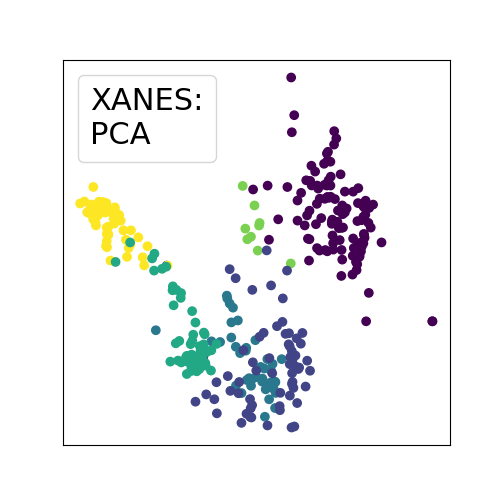

<IPython.core.display.Javascript object>


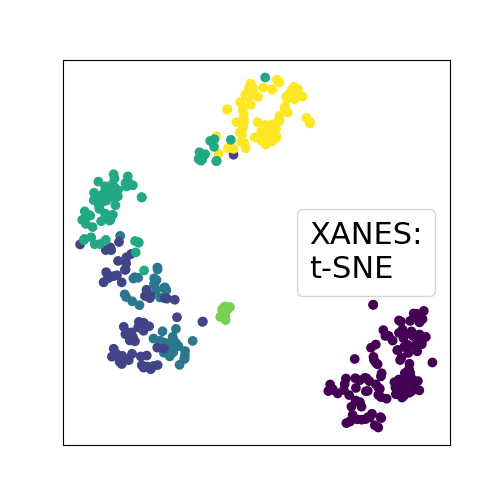

<function __main__.onselect(sel)>

In [17]:
mplcursors.cursor(plot_dim_red(plt.subplots(figsize=(5,5)), XES_PCA, compoundtypes, 'PCA')).connect("add", onselect)
mplcursors.cursor(plot_dim_red(plt.subplots(figsize=(5,5)), XES_TSNE,compoundtypes, 't-SNE')).connect("add", onselect)
mplcursors.cursor(plot_dim_red(plt.subplots(figsize=(5,5)), XANES_PCA, compoundtypes, 'PCA', mode='XANES')).connect("add", onselect)
mplcursors.cursor(plot_dim_red(plt.subplots(figsize=(5,5)), XANES_TSNE, compoundtypes, 't-SNE', mode='XANES')).connect("add", onselect)

## Spectra + Latent Space Combined

<IPython.core.display.Javascript object>


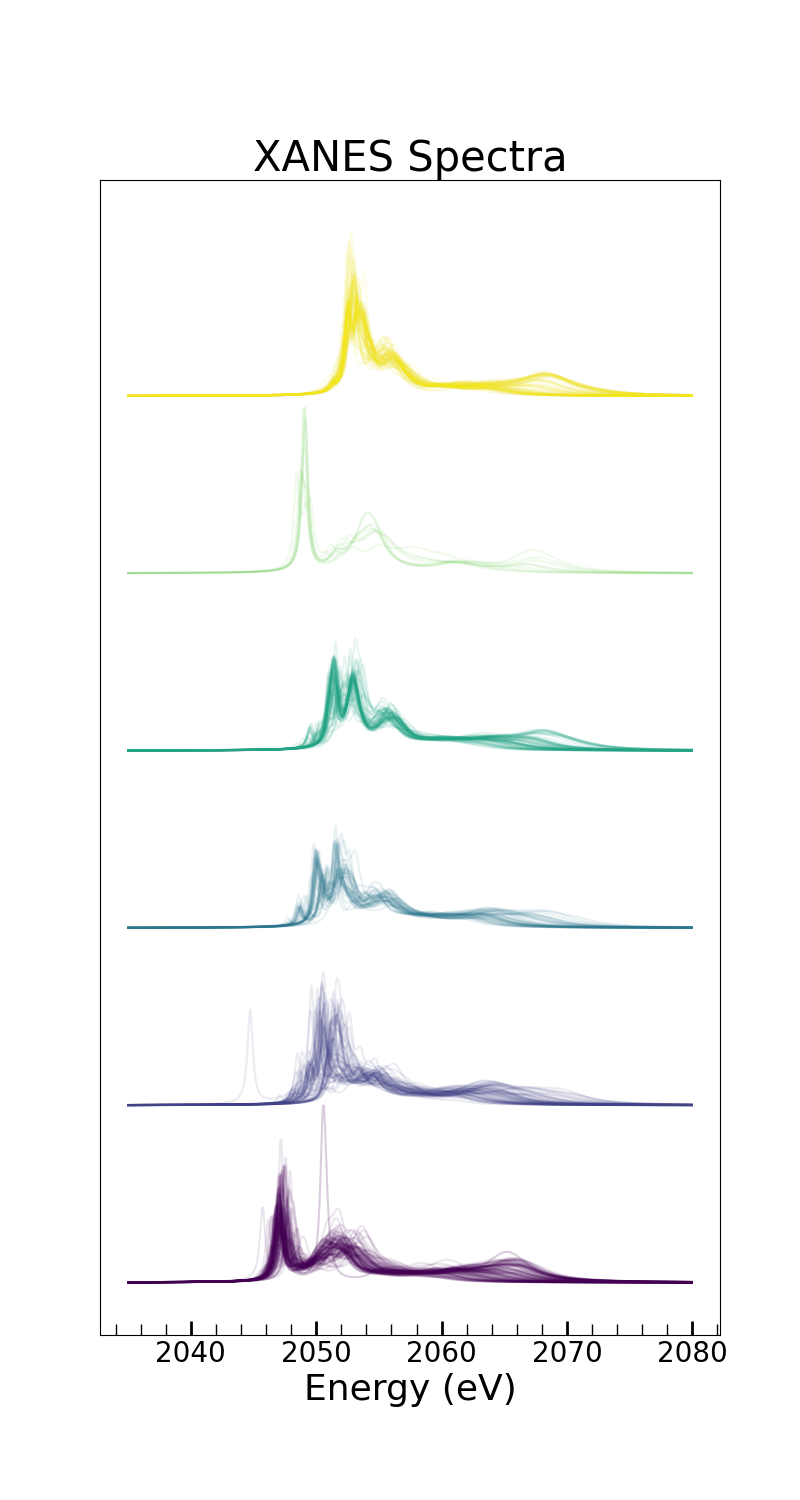

<IPython.core.display.Javascript object>


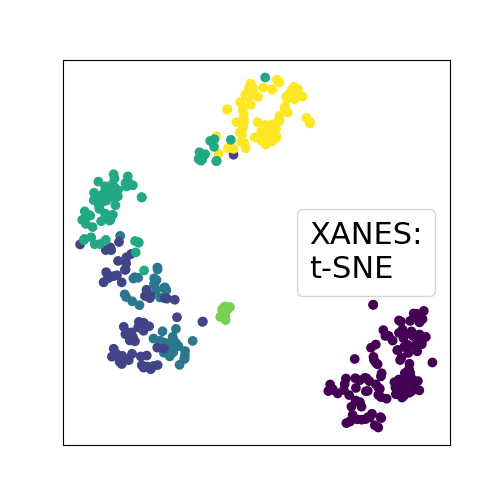

<function __main__.highlight_dot(sel)>

In [18]:
linktopubchem = True

oldlineprops = {}

def highlight_spectra(sel):
    sel.annotation.set_text( \
        str(CIDS[sel.target.index])+','+str(compoundtypes[sel.target.index]))
    if oldlineprops:
        spectra_lines[oldlineprops['index']].set_linewidth(oldlineprops['linewidth'])
        spectra_lines[oldlineprops['index']].set_color(oldlineprops['color'])
        spectra_lines[oldlineprops['index']].set_alpha(oldlineprops['alpha'])
    oldlineprops['index'] = sel.target.index
    oldlineprops['linewidth'] = spectra_lines[sel.target.index].get_lw()
    oldlineprops['color'] = spectra_lines[sel.target.index].get_c()
    oldlineprops['alpha'] = spectra_lines[sel.target.index].get_alpha()
    spectra_lines[sel.target.index].set_linewidth(3)
    spectra_lines[sel.target.index].set_color('red')
    spectra_lines[sel.target.index].set_alpha(1)
    if linktopubchem: webbrowser.open(f"https://pubchem.ncbi.nlm.nih.gov/image/imgsrv.fcgi?cid={CIDS[sel.target.index]}&t=l")

def unhighlight_spectra(sel):
    spectra_lines[sel.target.index].set_linewidth(oldlineprops['linewidth'])
    spectra_lines[sel.target.index].set_color(oldlineprops['color'])
    spectra_lines[sel.target.index].set_alpha(oldlineprops['alpha'])
        

olddotprops = {}

def highlight_dot(sel):
    #sel.annotation.set_text(str(CIDS[sel.target.index])+' '+str(types[sel.target.index]))
    if olddotprops:
        redspace_dots.set_edgecolors(olddotprops['colors'])
    olddotprops['colors'] = copy.deepcopy(redspace_dots.get_edgecolors())
    newdotedgecolors = copy.deepcopy(olddotprops['colors'])
    #webbroswer.open(str(len(olddotedgecolors)))
    #webbrowser.open(repr(sel.artist.get_label().split(',')[0]))
    index = CIDS.index(int(sel.artist.get_label().split(',')[0]))
    newdotedgecolors[index] = [1,0,0,1]
    redspace_dots.set_edgecolors(newdotedgecolors)
    if linktopubchem: webbrowser.open(f"https://pubchem.ncbi.nlm.nih.gov/image/imgsrv.fcgi?cid={CIDS[index]}&t=l")


def unhighlight_dot(sel):
    webbrowser.open('test')
    redspace_dots.set_edgecolors(olddotprops['colors'])
    
spectra_lines = Rainbow_spaghetti_plot_types_stack(plt.subplots(figsize=(8,15)), XANESenergy, XANES, compoundtypes, mode='XANES')
redspace_dots = plot_dim_red(plt.subplots(figsize=(5,5)), XANES_TSNE, compoundtypes, 't-SNE', mode='XANES')

dotcursor = mplcursors.cursor(redspace_dots)
dotcursor.connect("add", highlight_spectra)
#dotcursor.connect("remove", unhighlight_spectra)

linecursor = mplcursors.cursor(spectra_lines, highlight=True,
                  highlight_kwargs={'color':'pink', 'alpha':1, 'linewidth':3, 'markeredgewidth':0})
linecursor.connect("add", highlight_dot)
#linecursor.connect("remove", unhighlight_dot)

In [19]:
# Uncomment and run the line below to stop it linking to PubChem when you click on the figures
# linktopubchem = False